# Classification

Our last task is to train a classifier on our dataset. First, we try to train a few classification algorithms with default settings and see their results and compare them. Below there is the visualisation of algorithms - their confusion matrix and learning curve when the dataset size is changing.

## Training dataset

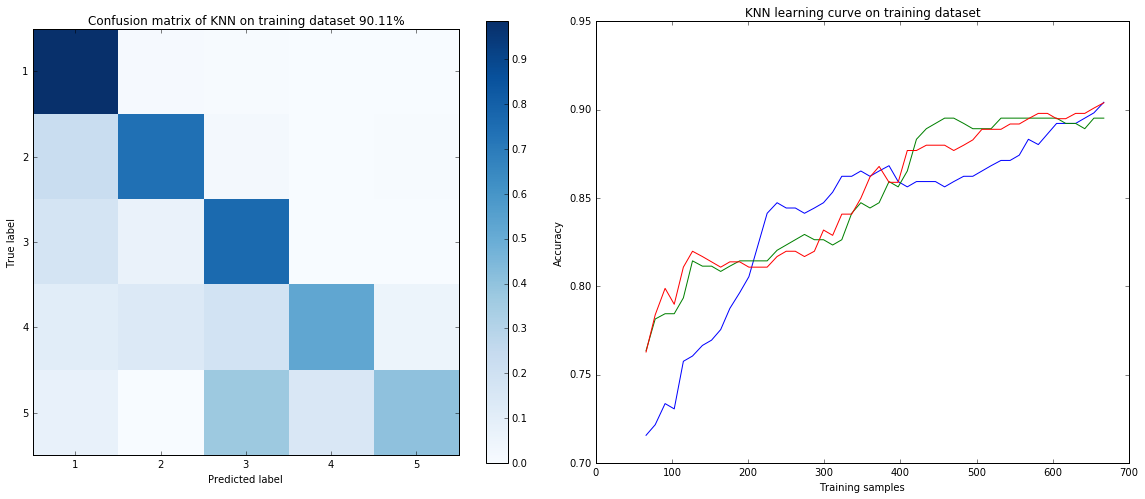

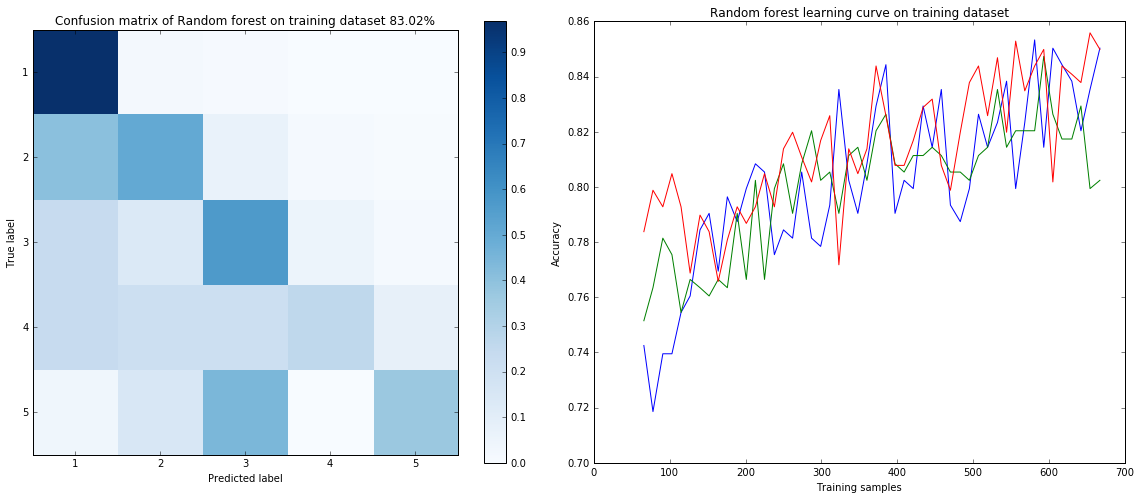

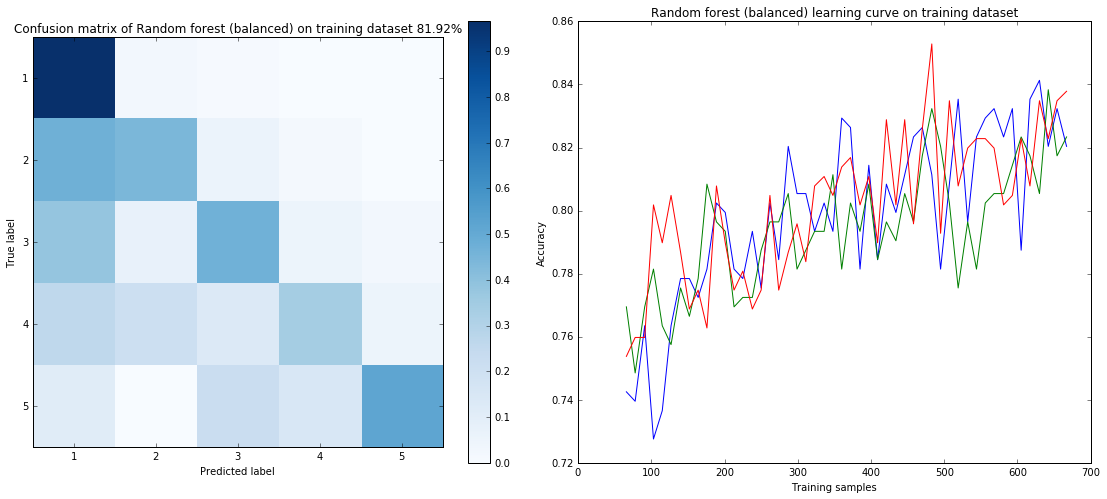

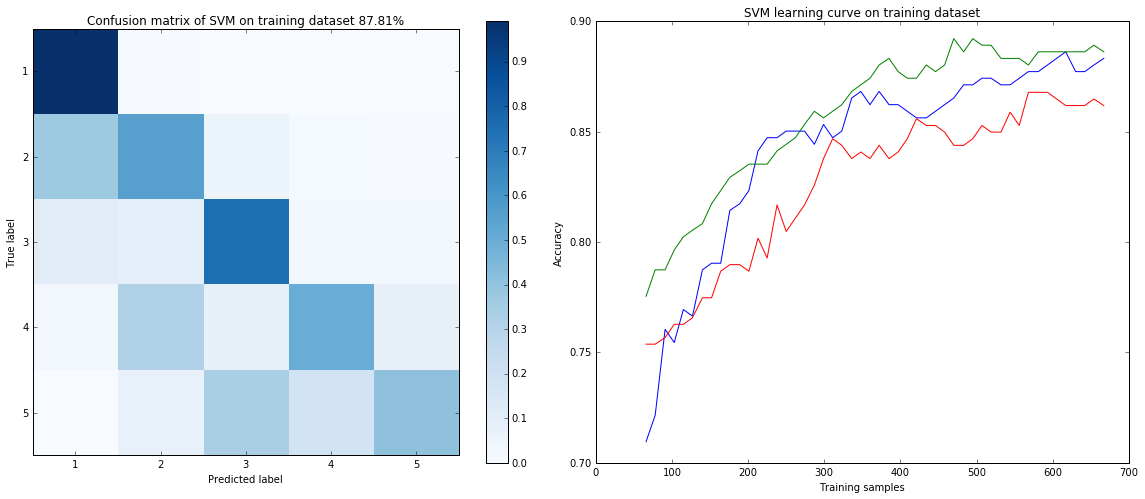

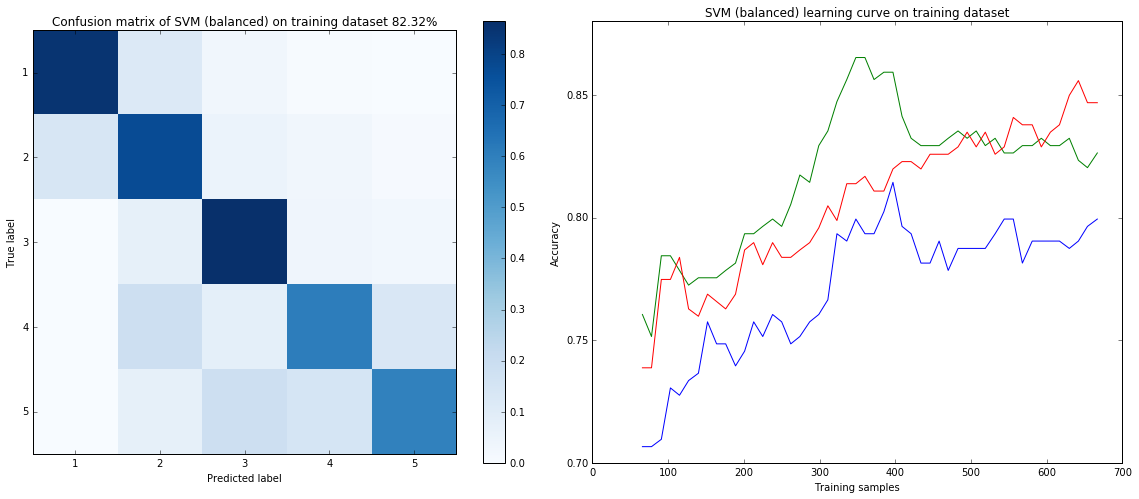

In [1]:
# comparison of different classification algorithms on training dataset using confusion matrix and learning curve

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.cross_validation import StratifiedKFold
from sklearn.learning_curve import learning_curve

#load data
sample = pd.read_csv('../data/sample-classified.csv')
X = sample.values[:,1:-1].astype(float)
y = sample.values[:,-1].astype(int)

# initialize scaler
std_scaler = StandardScaler().fit(X)

X = std_scaler.transform(X)

K = 3

def evaluate(clf, label):
    skf = StratifiedKFold(y, K)

    accuracy = 0
    conf_matrix = np.zeros((5, 5))

    for train, test in skf:
        # predict and compute accuracy and confusion matrix
        y_pred = clf.fit(X[train], y[train]).predict(X[test])
        accuracy += accuracy_score(y[test], y_pred)
        
        conf_matrix = np.add(conf_matrix, confusion_matrix(y[test], y_pred))

    conf_matrix = np.divide(conf_matrix, K)

    # normalize
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    sizes = np.linspace(0.1, 1.0, 50)
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, train_sizes=sizes)
    
    f, (cm, lc) = plt.subplots(1, 2, figsize=(16, 7))
    
    plt.sca(cm)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix of {} on training dataset {:.2%}'.format(label, accuracy / K))
    plt.colorbar()
    plt.xticks(np.arange(5), np.arange(1,6))
    plt.yticks(np.arange(5), np.arange(1,6))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.sca(lc)
    plt.plot(train_sizes, test_scores)
    plt.title('{} learning curve on training dataset'.format(label))
    plt.xlabel("Training samples")
    plt.ylabel("Accuracy")
    
    plt.tight_layout()
    plt.show()
    
# initialize classifier
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
rf_blncd = RandomForestClassifier(class_weight='balanced')
svm = SVC()
svm_blncd = SVC(class_weight='balanced')

# evaluate measurements
evaluate(knn, 'KNN')
evaluate(rf, 'Random forest')
evaluate(rf_blncd, 'Random forest (balanced)')
evaluate(svm, 'SVM')
evaluate(svm_blncd, 'SVM (balanced)')

### Summary

We see that all classifiers tend to predict worse rating than actual one. This is probably due to lack of great readmes. balanced SVM is apparently very confident in predicting classes 1-3 and gives good results in 4-5 case. It's interesting (but a bit sad) that random forest and KNN has noticeable ammount of predictions where the predicted label is 1 (bad) but the actual label is 5 (great).

The learning curve is approximately linear. In SVM case the accuracy can get stuck or even decrease at the 80%+ dataset size. The learning curve of random forest is pretty chaotic in comparison with other algorithms which are rather stable.

## Testing dataset

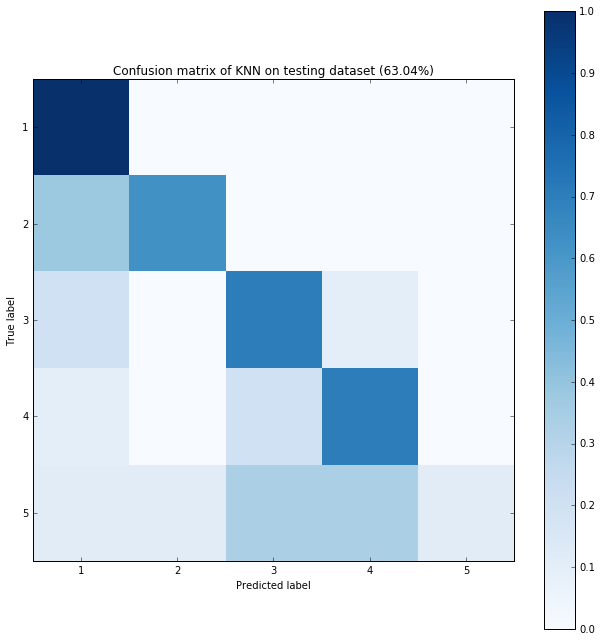

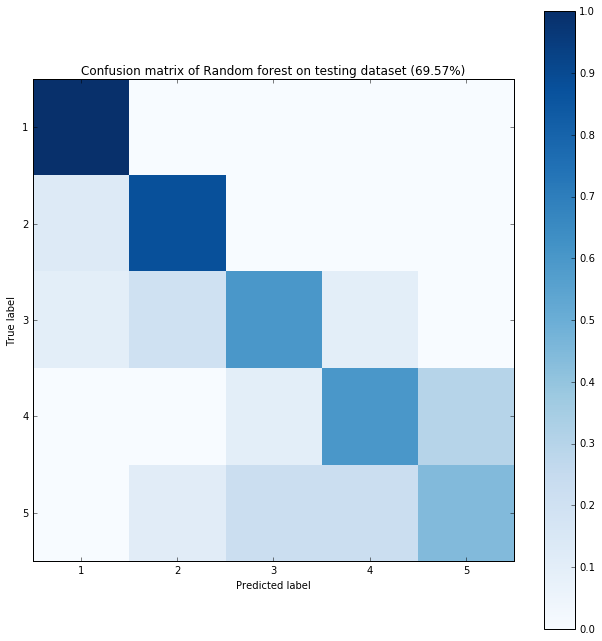

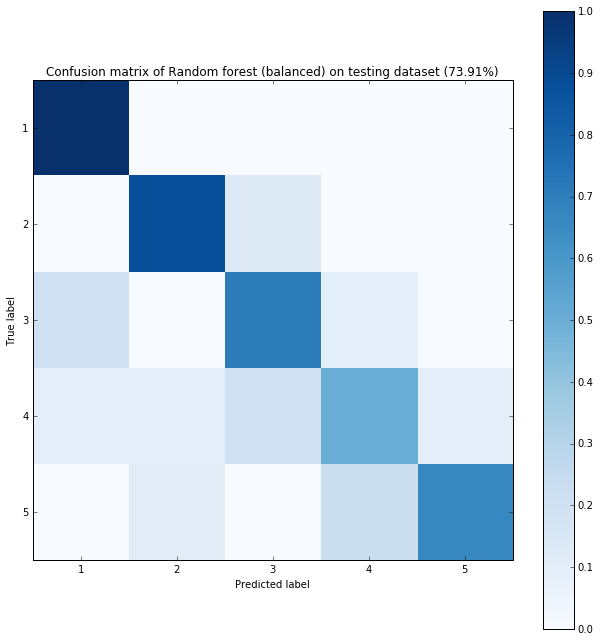

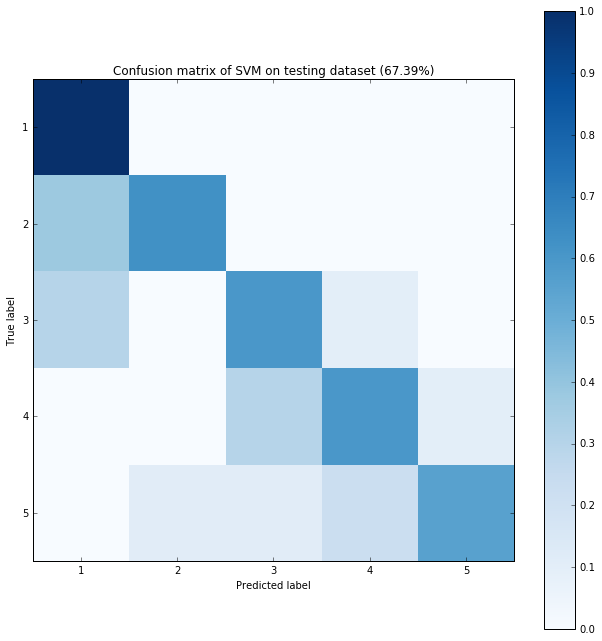

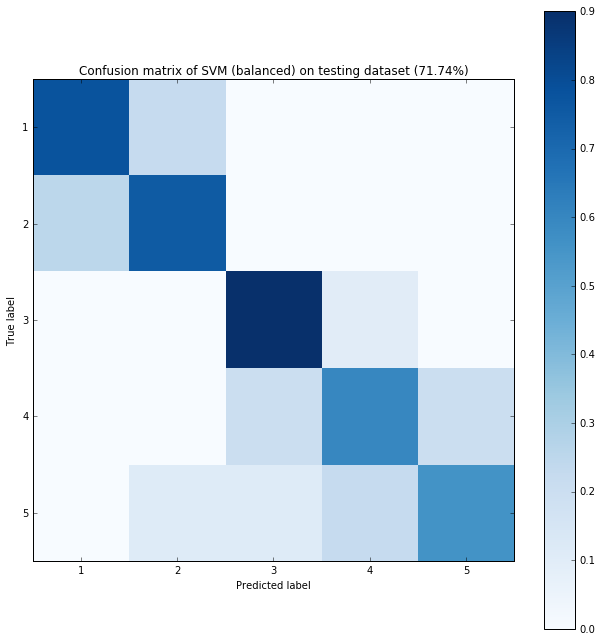

In [2]:
# comparison of different classification algorithms on testing dataset using confusion matrix

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#load data
sample = pd.read_csv('../data/sample-classified.csv')
X = sample.values[:,1:-1].astype(float)
y = sample.values[:,-1].astype(int)

test = pd.read_csv('../data/classified-manually-scaled.csv')
Xt = test.values[:,1:-1].astype(float)
yt = test.values[:,-1].astype(int)

# initialize scaler
std_scaler = StandardScaler()

std_scaler.fit(np.concatenate((X, Xt)))

X = std_scaler.transform(X)
Xt = std_scaler.transform(Xt)

def evaluate(clf, label):
    y_pred = clf.fit(X, y).predict(Xt)
    
    accuracy = accuracy_score(yt, y_pred)
    conf_matrix = confusion_matrix(yt, y_pred)

    # normalize
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(9, 9))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix of {} on testing dataset ({:.2%})'.format(label, accuracy))
    plt.colorbar()
    plt.xticks(np.arange(5), np.arange(1,6))
    plt.yticks(np.arange(5), np.arange(1,6))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
# initialize classifiers
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
rf_blncd = RandomForestClassifier(class_weight='balanced')
svm = SVC()
svm_blncd = SVC(class_weight='balanced')

# evaluate measurements
evaluate(knn, 'KNN')
evaluate(rf, 'Random forest')
evaluate(rf_blncd, 'Random forest (balanced)')
evaluate(svm, 'SVM')
evaluate(svm_blncd, 'SVM (balanced)')

### Summary

Results on testing dataset are similar to ones on training dataset, just a little bit worse.

## Validation curves over parameters

We plot validation curves over some paramaters of our classification algorithms in order to acquire an insight of behaviour on our data.

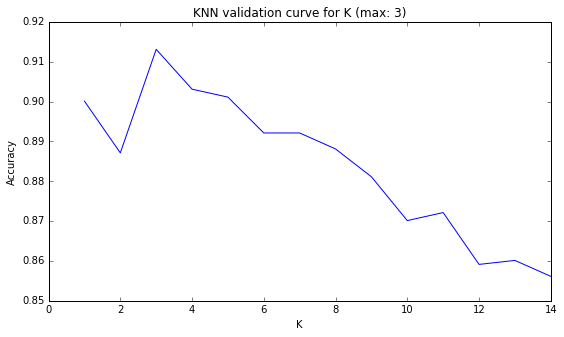

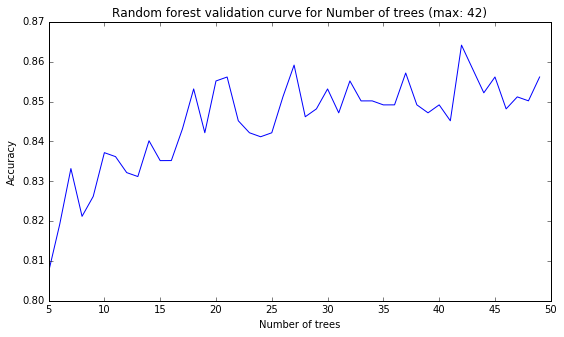

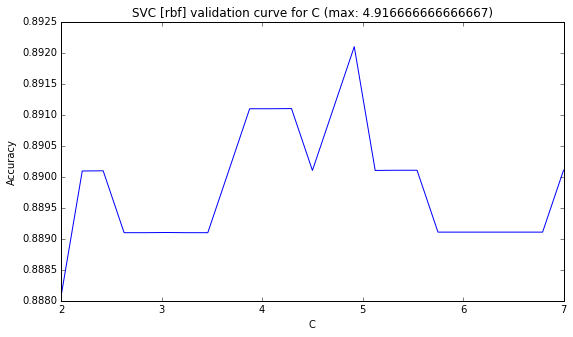

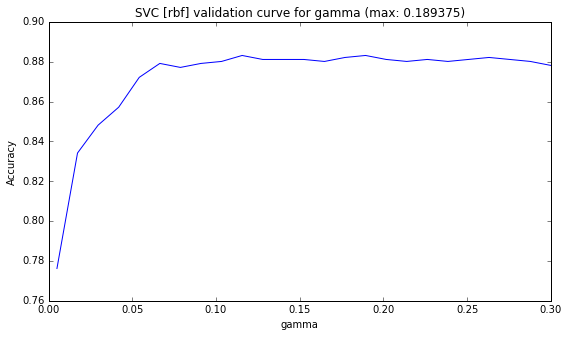

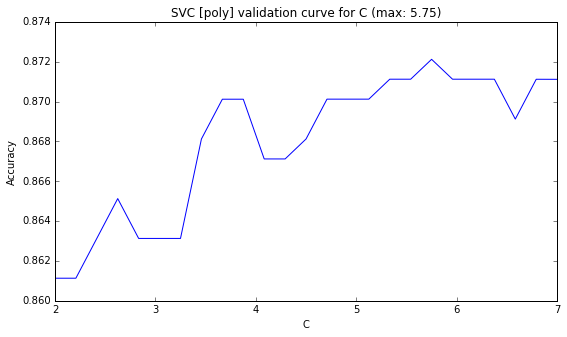

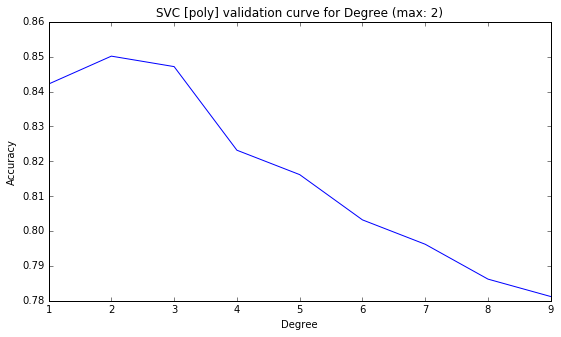

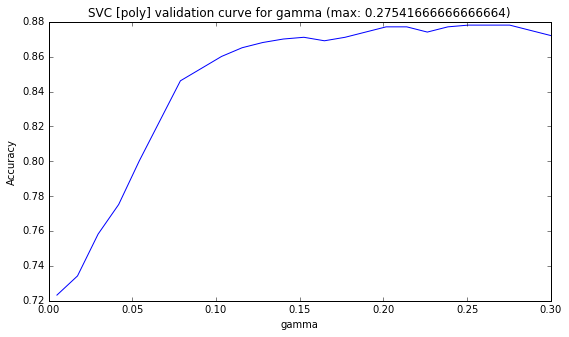

In [3]:
# validation of specific parameters of classification algorithms

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.learning_curve import validation_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#load data
sample = pd.read_csv('../data/sample-classified.csv')
X = sample.values[:,1:-1].astype(float)
y = sample.values[:,-1].astype(int)

# initialize scaler
std_scaler = StandardScaler()

std_scaler.fit(X)
X = std_scaler.transform(X)

def evaluate(clf, label, param_label, param, param_range):
    _, test_scores = validation_curve(
        clf, X, y, param_name=param, param_range=param_range, scoring='accuracy')
    
    scores = np.array(list(map(lambda x: np.mean(x), test_scores)))
    
    maximum = param_range[np.argmax(scores)]
    
    plt.figure(figsize=(9, 5))
    plt.plot(param_range, scores)
    plt.title('{} validation curve for {} (max: {})'.format(label, param_label, maximum))
    plt.xlabel('{}'.format(param_label))
    plt.ylabel('Accuracy')
    
    plt.show()
    
# evaluate validations
evaluate(KNeighborsClassifier(), 'KNN', 'K', 'n_neighbors', np.arange(1, 15))
evaluate(RandomForestClassifier(), 'Random forest', 'Number of trees', 'n_estimators', np.arange(5, 50))
evaluate(SVC(kernel='rbf'), 'SVC [rbf]', 'C', 'C', np.linspace(2, 7, 25))
evaluate(SVC(kernel='rbf'), 'SVC [rbf]', 'gamma', 'gamma', np.linspace(0.005, 0.3, 25))
evaluate(SVC(kernel='poly'), 'SVC [poly]', 'C', 'C', np.linspace(2, 7, 25))
evaluate(SVC(kernel='poly'), 'SVC [poly]', 'Degree', 'degree', np.arange(1, 10))
evaluate(SVC(kernel='poly'), 'SVC [poly]', 'gamma', 'gamma', np.linspace(0.005, 0.3, 25))

## Choosing a classifier

At the and of our process we search over parameters of our classification algorithms and measure their accuracy both on training and testing dataset.

=== KNN ===
{'n_neighbors': 3}
=== Random forest ===
{'n_estimators': 47}
=== Random forest (balanced) ===
{'n_estimators': 22}
=== SVM ===
{'gamma': 0.16249999999999998, 'kernel': 'rbf', 'degree': 3, 'C': 5.0}
=== SVM (balanced) ===
{'gamma': 0.5, 'kernel': 'poly', 'degree': 4, 'C': 6.333333333333333}


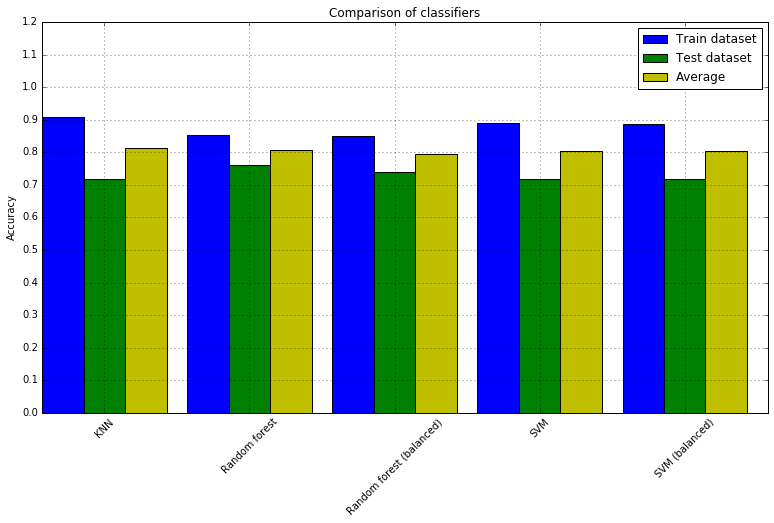

In [4]:
# measuring accuracy of different classification algorithms on training and testing dataset

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

#load data
sample = pd.read_csv('../data/sample-classified.csv')
X = sample.values[:,1:-1].astype(float)
y = sample.values[:,-1].astype(int)

test = pd.read_csv('../data/classified-manually-scaled.csv')
Xt = test.values[:,1:-1].astype(float)
yt = test.values[:,-1].astype(int)

# initialize scaler
std_scaler = StandardScaler()

std_scaler.fit(np.concatenate((X, Xt)))

X = std_scaler.transform(X)
Xt = std_scaler.transform(Xt)

K = 3

def evaluate(clf, params):
    grid = GridSearchCV(clf, params)
    
    skf = StratifiedKFold(y, K)

    accuracy = 0

    for train, test in skf:
        # predict and compute accuracy
        y_pred = grid.fit(X[train], y[train]).predict(X[test])
        accuracy += accuracy_score(y[test], y_pred)
    
    grid.fit(X, y)
    
    all_params = grid.best_estimator_.get_params()
    filtered_params = dict()
    for param in all_params.keys():
        if isinstance(params, list):
            flat_params = dict()
            for item in params:
                flat_params.update(item)
            params = flat_params
        
        if param in params:
            filtered_params[param] = all_params[param]
    
    return accuracy / K, accuracy_score(yt, grid.predict(Xt)), filtered_params

def visualize(results):
    train_scores = []
    test_scores = []
    avg_scores = []
    labels = []
    
    for result in results:
        train_scores.append(result[0][0])
        test_scores.append(result[0][1])
        avg_scores.append((result[0][0] + result[0][1]) / 2)
        labels.append(result[1])
        
        print('=== {} ==='.format(result[1]))
        print(result[0][2])

    x_axis = np.arange(len(train_scores))
    width = 2/7

    fig, ax = plt.subplots(figsize=(13, 7))

    bars1 = ax.bar(x_axis, train_scores, width, color='b')
    bars2 = ax.bar(x_axis + width, test_scores, width, color='g')
    bars3 = ax.bar(x_axis + 2 * width, avg_scores, width, color='y')

    ax.set_title('Comparison of classifiers')
    ax.set_ylabel('Accuracy')
    ax.set_yticks(np.linspace(0, 1.2, 13))
    ax.set_xticks(x_axis + 3/2 * width)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend((bars1[0], bars2[0], bars3[0]), ('Train dataset', 'Test dataset', 'Average'))

    plt.grid(True)
    plt.show()
    
    
# initialize classifiers
knn = KNeighborsClassifier()
rf = RandomForestClassifier()
rf_blncd = RandomForestClassifier(class_weight='balanced')
svm = SVC()
svm_blncd = SVC(class_weight='balanced')

# evaluate measurements
results = [
    (evaluate(knn, {'n_neighbors': [3, 5]}), 'KNN'),
    (evaluate(rf, {'n_estimators': np.arange(5, 50)}), 'Random forest'),
    (evaluate(rf_blncd, {'n_estimators': np.arange(5, 50)}), 'Random forest (balanced)'),
    (evaluate(svm, [
                {
                    'C': np.linspace(2, 10, 25),
                    'gamma': np.linspace(0.05, 0.5, 25),
                    'kernel': ['rbf']
                },
                {
                    'C': np.linspace(2, 10, 25),
                    'gamma': np.linspace(0.05, 0.5, 25),
                    'degree': np.arange(1, 5),
                    'kernel': ['poly']
                }]), 'SVM'),
    (evaluate(svm_blncd, [
                {
                    'C': np.linspace(2, 10, 25),
                    'gamma': np.linspace(0.05, 0.5, 25),
                    'kernel': ['rbf']
                },
                {
                    'C': np.linspace(2, 10, 25),
                    'gamma': np.linspace(0.05, 0.5, 25),
                    'degree': np.arange(1, 5),
                    'kernel': ['poly']
                }]), 'SVM (balanced)')
]

visualize(results)

## Winner

We chose the balanced SVM algorithm despite the fact that KNN has higher accuracy on training dataset and Random forest has higher accuracy on testing dataset. In average, the results are very similar for all the methods, KNN is a bit better because of its accuracy on training dataset. We chose balanced SVM, because it has sufficient average accuracy and as seen from confusion matrix it gives mostly just "local" error (e.g. 1 actual, 2 predicted) and not those cases when great (5) readmes are marked as bad (1). As the final step, we dump trained classifier (and scaler) onto the filesystem in order to use it in the future.

In [5]:
# training a SVM classifier and dumping that classifier onto the filesystem

%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.externals import joblib

#load data
sample = pd.read_csv('../data/sample-classified.csv')
X = sample.values[:,1:-1].astype(float)
y = sample.values[:,-1].astype(int)

test = pd.read_csv('../data/classified-manually-scaled.csv')
Xt = test.values[:,1:-1].astype(float)
yt = test.values[:,-1].astype(int)

X = np.concatenate((X, Xt))
y = np.concatenate((y, yt))

# initialize scaler
std_scaler = StandardScaler()

std_scaler.fit(X)
X = std_scaler.transform(X)    
    
# initialize classifier
svm = SVC(class_weight='balanced')

params = [
    {
        'C': np.linspace(2, 10, 25),
        'gamma': np.linspace(0.05, 0.5, 25),
        'kernel': ['rbf']
    },
    {
        'C': np.linspace(2, 10, 25),
        'gamma': np.linspace(0.05, 0.5, 25),
        'degree': np.arange(1, 5),
        'kernel': ['poly']
    }
]

grid = GridSearchCV(svm, params)

grid.fit(X, y)

joblib.dump(std_scaler, '../classifier/serialized/scaler.pkl')
joblib.dump(grid.best_estimator_, '../classifier/serialized/classifier.pkl')

['../classifier/serialized/classifier.pkl',
 '../classifier/serialized/classifier.pkl_01.npy',
 '../classifier/serialized/classifier.pkl_02.npy',
 '../classifier/serialized/classifier.pkl_03.npy',
 '../classifier/serialized/classifier.pkl_04.npy',
 '../classifier/serialized/classifier.pkl_05.npy',
 '../classifier/serialized/classifier.pkl_06.npy',
 '../classifier/serialized/classifier.pkl_07.npy',
 '../classifier/serialized/classifier.pkl_08.npy',
 '../classifier/serialized/classifier.pkl_09.npy',
 '../classifier/serialized/classifier.pkl_10.npy',
 '../classifier/serialized/classifier.pkl_11.npy']